 Избор на податочно множество за Алцхајмерова болест и негова анализа преку соодветна методологија.

# Импорти

In [10]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



In [11]:
%pip install xgboost


вчитување на податоците

In [12]:
df = pd.read_csv('/content/alzheimers_disease_data.csv')
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751.0,73.0,Male,Caucasian,Bachelor's,22.927749,NaN,13.297218,6.327112,1.347214,...,No,No,1.725883,No,No,No,Yes,No,No,XXXConfid
1,4752.0,89.0,Male,Caucasian,No,26.827681,NaN,4.542524,7.619885,0.518767,...,No,No,2.592424,No,No,No,No,NaN,No,XXXConfid
2,4753.0,73.0,Male,Other,High School,17.795882,No,19.555085,7.844988,1.826335,...,No,No,7.119548,No,Yes,No,Yes,No,No,XXXConfid
3,4754.0,74.0,Female,Caucasian,High School,33.800817,Yes,12.209266,8.428001,7.435604,...,No,Yes,6.481226,No,No,No,No,No,No,XXXConfid
4,4755.0,89.0,Male,Caucasian,No,NaN,No,18.454356,6.310461,NaN,...,No,No,0.014691,No,No,Yes,Yes,No,No,XXXConfid


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2055 non-null   float64
 1   Age                        2042 non-null   float64
 2   Gender                     2024 non-null   object 
 3   Ethnicity                  2044 non-null   object 
 4   EducationLevel             2041 non-null   object 
 5   BMI                        2017 non-null   float64
 6   Smoking                    2050 non-null   object 
 7   AlcoholConsumption         2032 non-null   float64
 8   PhysicalActivity           2053 non-null   float64
 9   DietQuality                2031 non-null   float64
 10  SleepQuality               2045 non-null   float64
 11  FamilyHistoryAlzheimers    2040 non-null   object 
 12  CardiovascularDisease      2031 non-null   object 
 13  Diabetes                   2034 non-null   objec

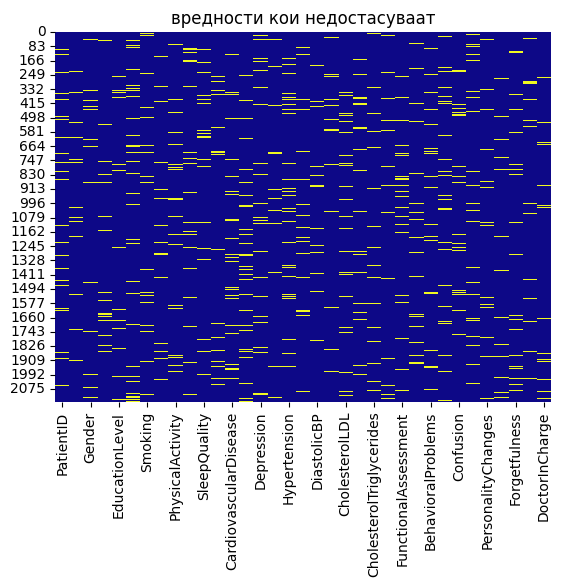

                       column  percent missing
0                   PatientID         4.374128
1                         Age         4.979060
2                      Gender         5.816659
3                   Ethnicity         4.885993
4              EducationLevel         5.025593
5                         BMI         6.142392
6                     Smoking         4.606794
7          AlcoholConsumption         5.444393
8            PhysicalActivity         4.467194
9                 DietQuality         5.490926
10               SleepQuality         4.839460
11    FamilyHistoryAlzheimers         5.072127
12      CardiovascularDisease         5.490926
13                   Diabetes         5.351326
14                 Depression         4.606794
15                 HeadInjury         4.792927
16               Hypertension         5.630526
17                 SystolicBP         4.746394
18                DiastolicBP         4.141461
19           CholesterolTotal         5.490926
20           

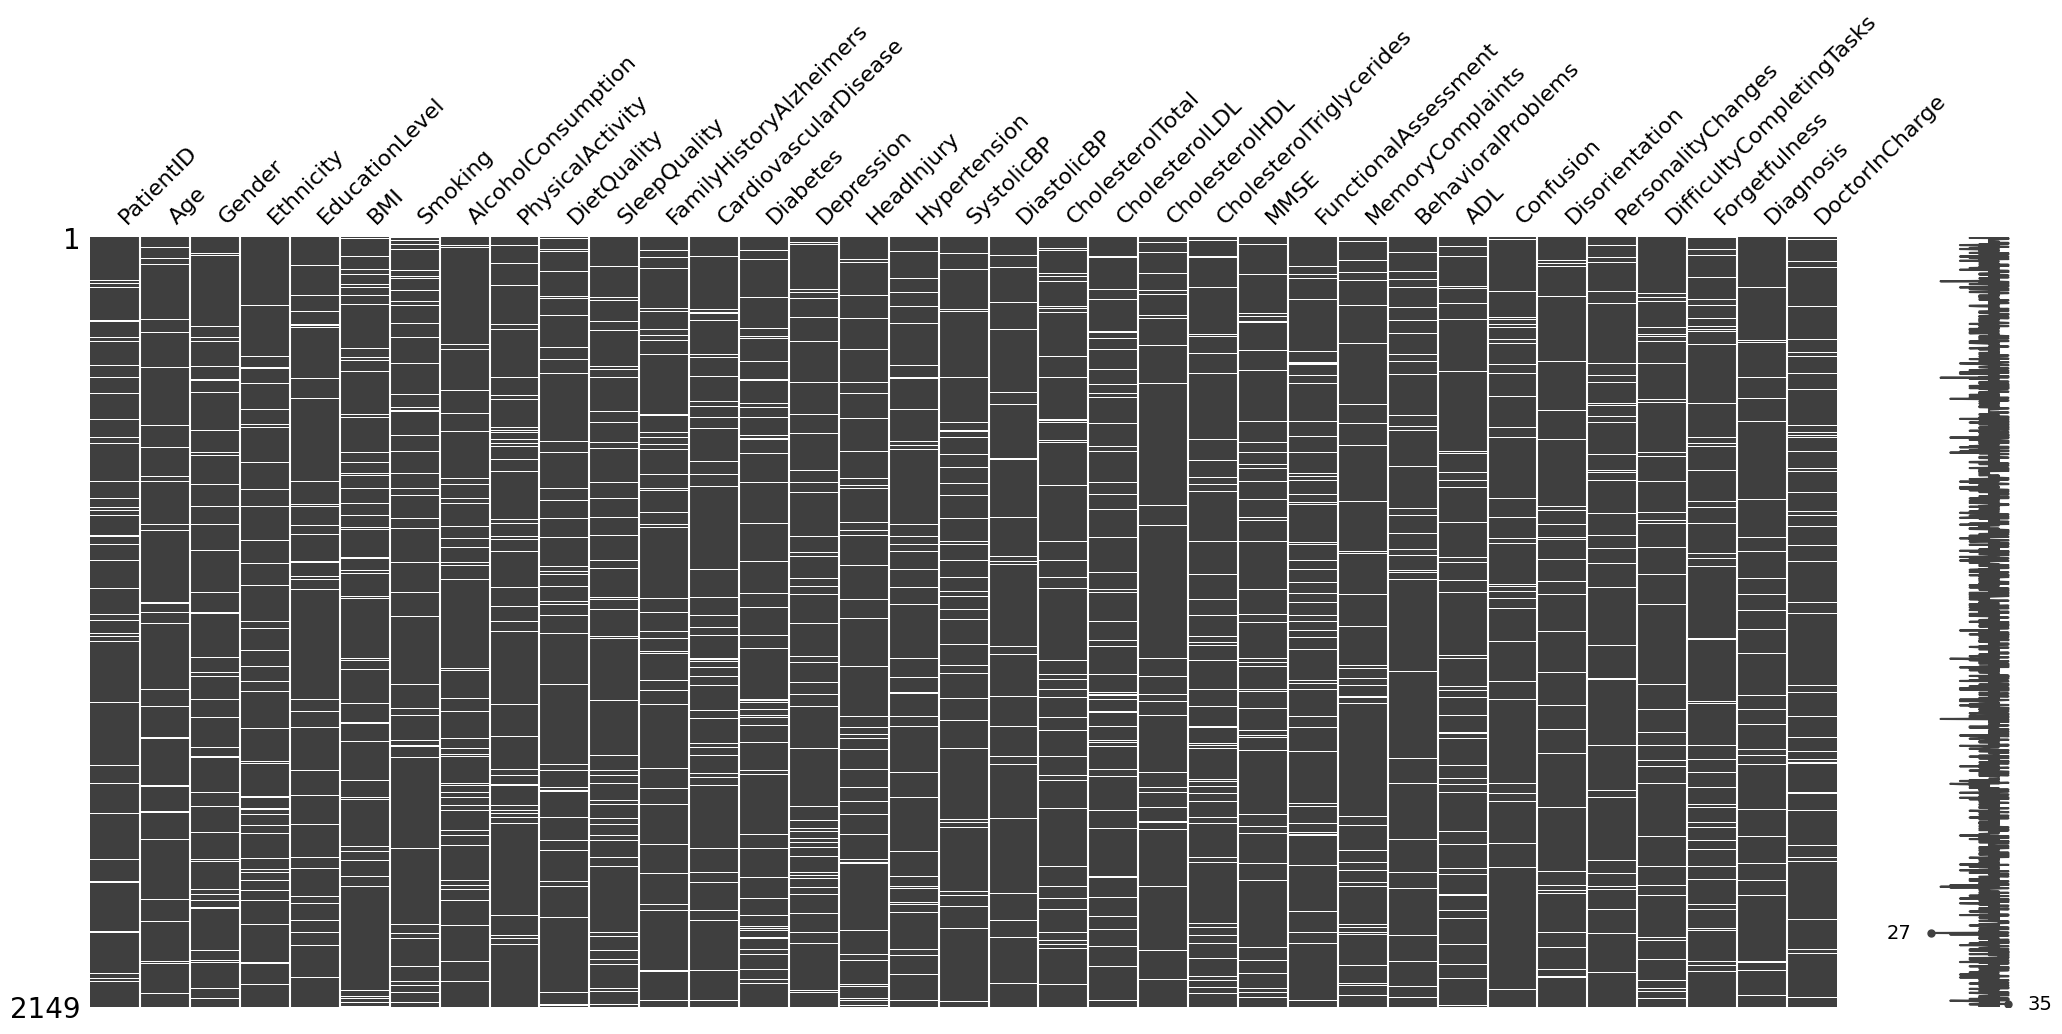

In [13]:
df.info()
sns.heatmap(df.isnull(), cbar=False, cmap='plasma')
plt.title("вредности кои недостасуваат")
plt.show()
missing_percent = df.isnull().sum() / len(df) * 100
missing_percent = missing_percent.reset_index().rename(columns={"index": "column", 0: "percent missing"})
print(missing_percent)
msno.matrix(df)
plt.show()


Анализа на податоците и визуализација

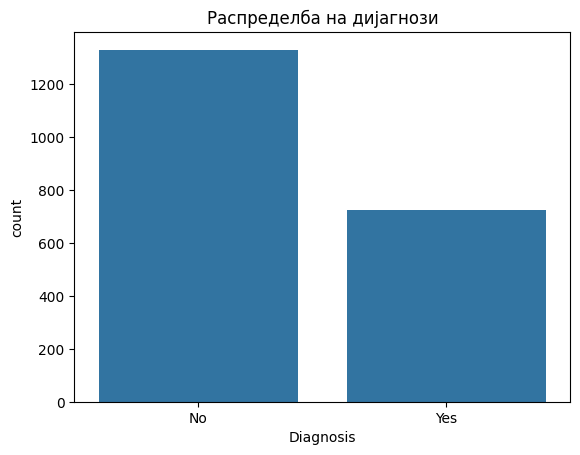

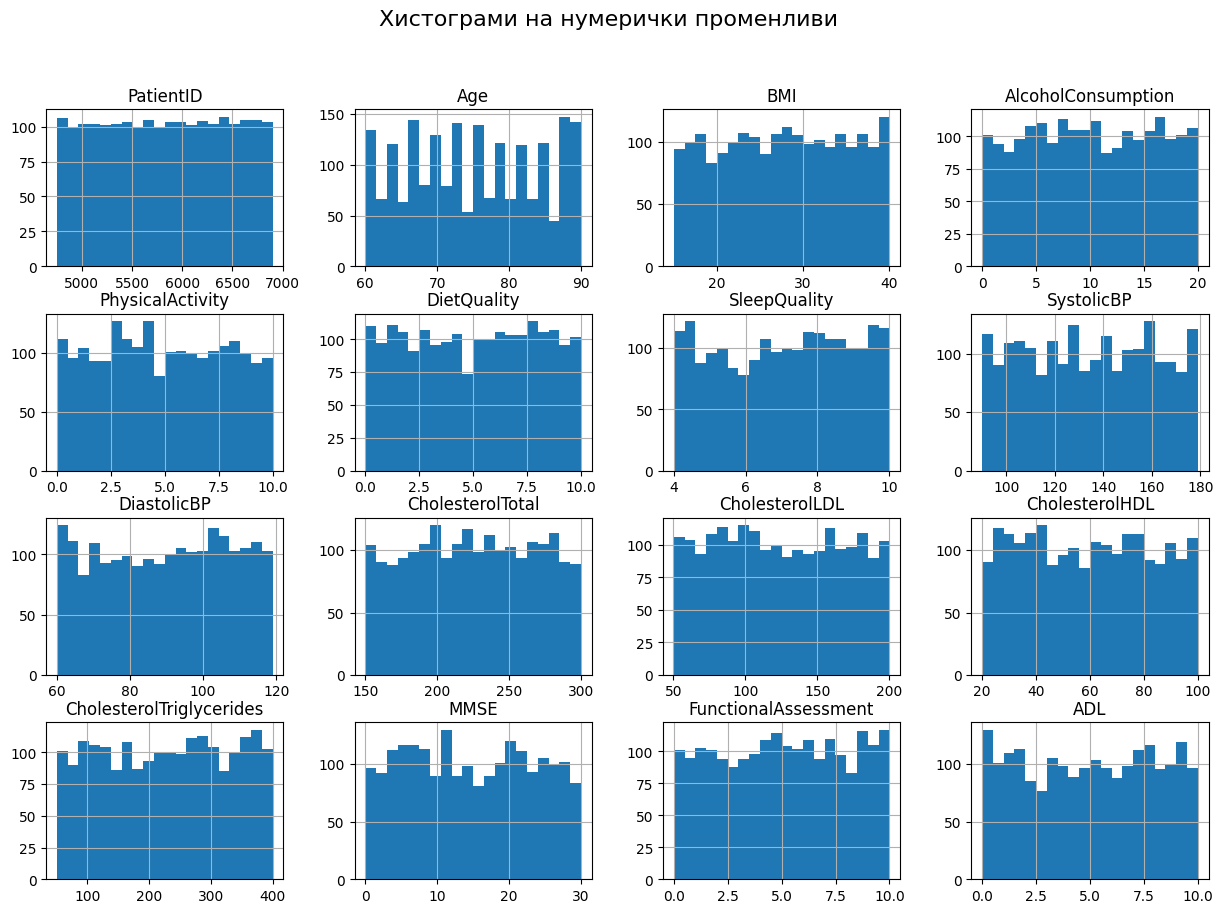

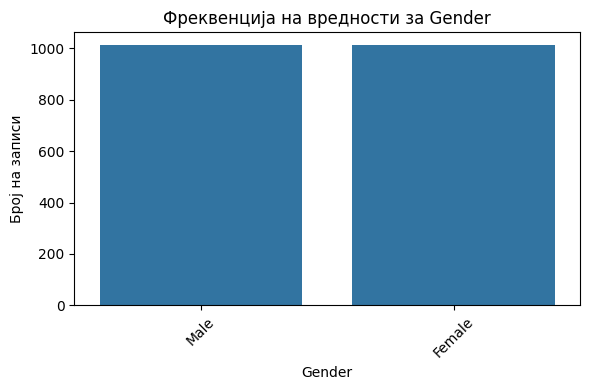

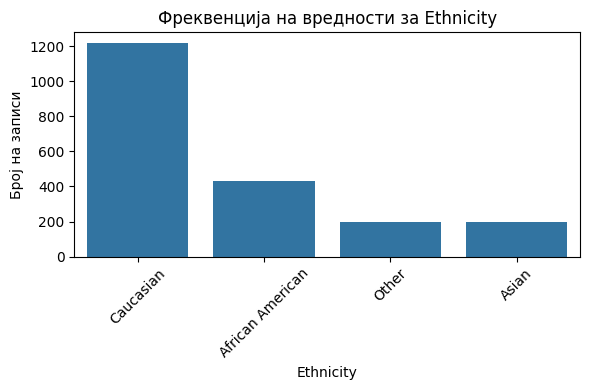

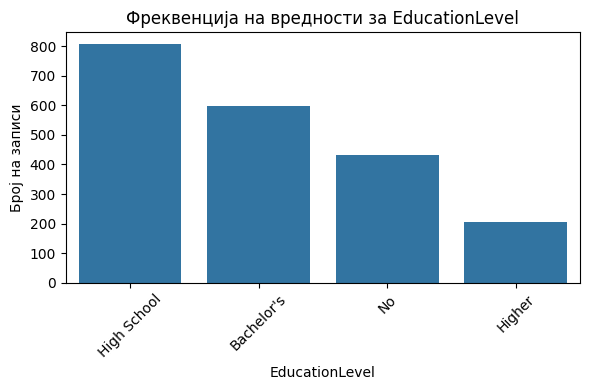

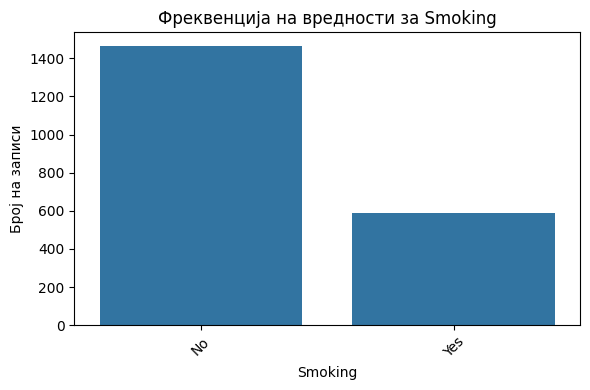

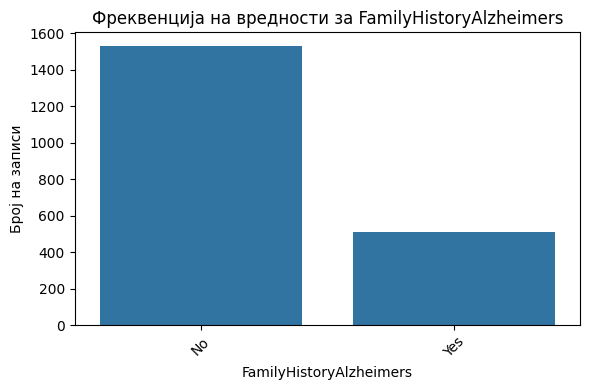

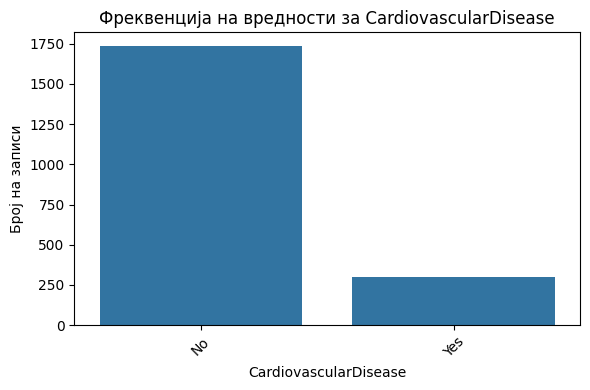

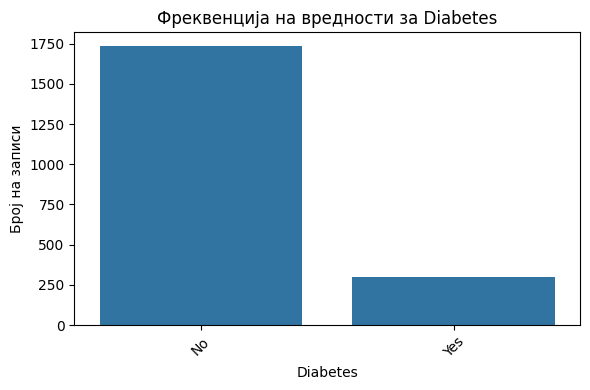

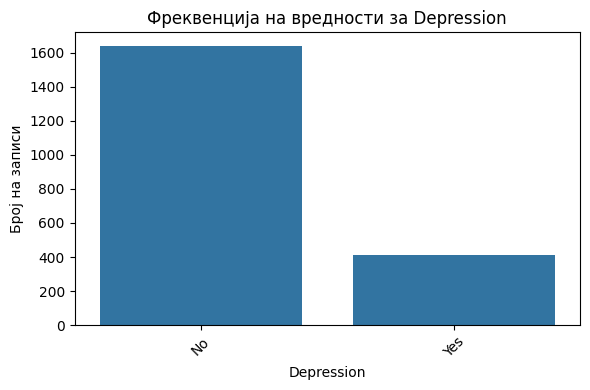

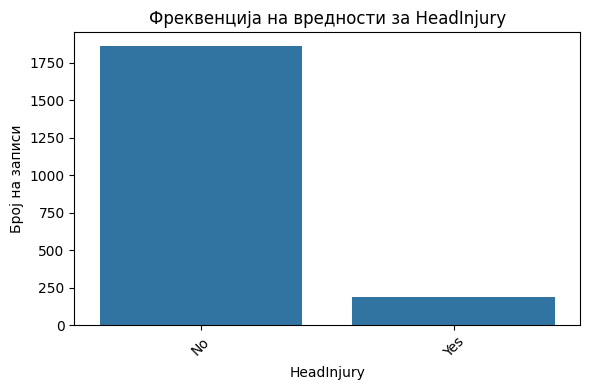

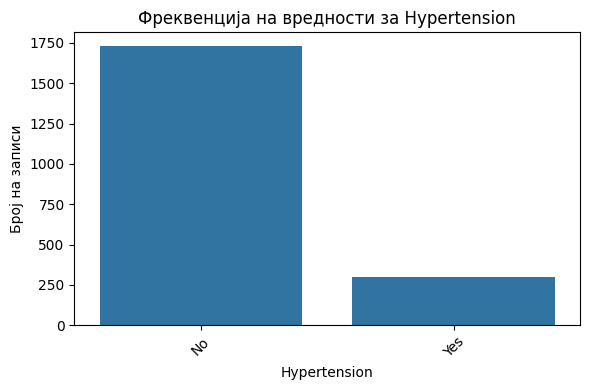

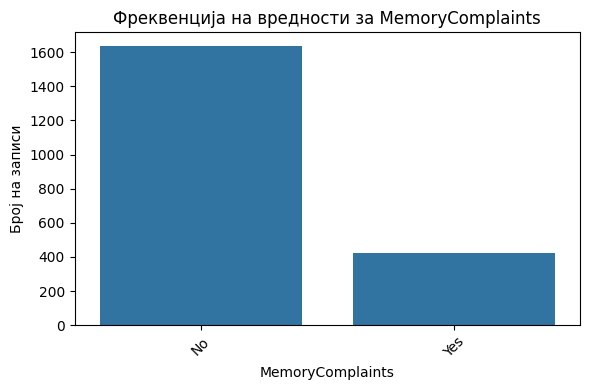

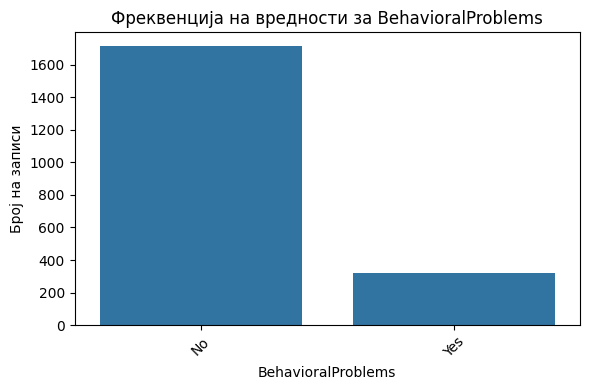

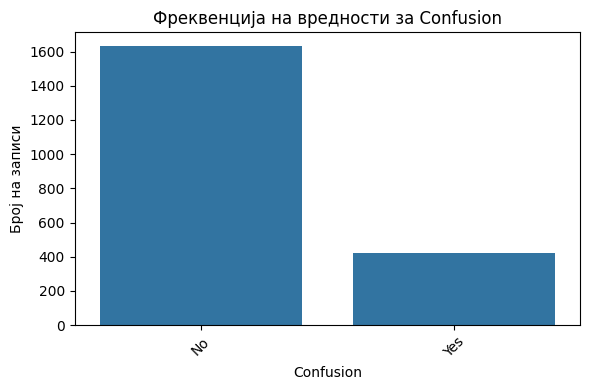

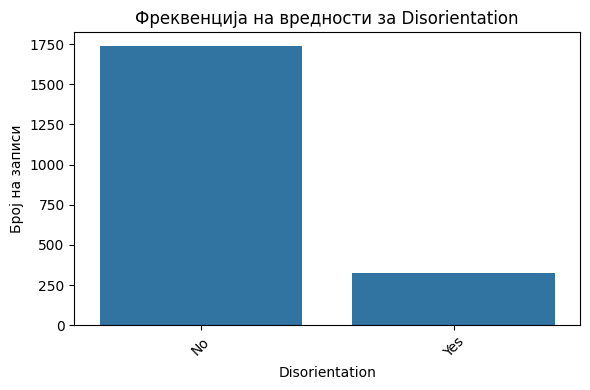

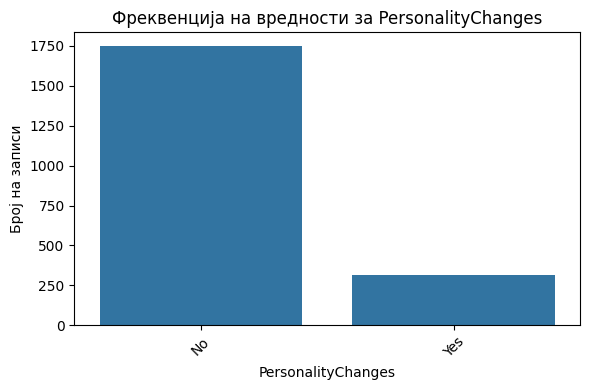

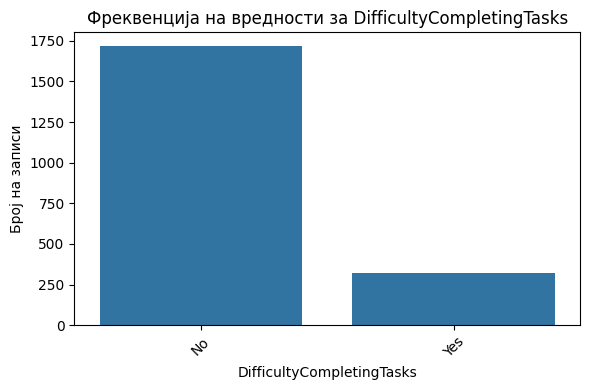

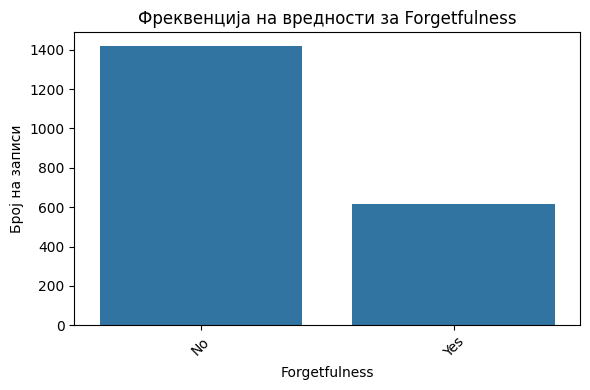

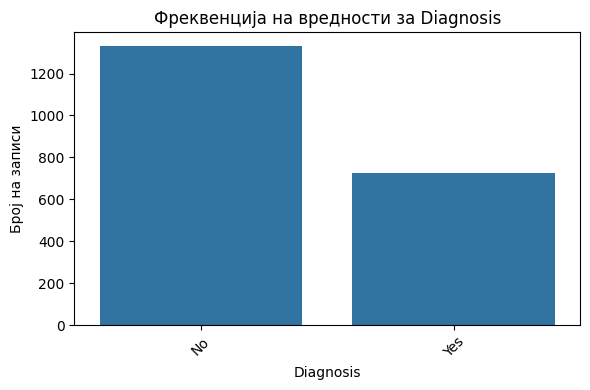

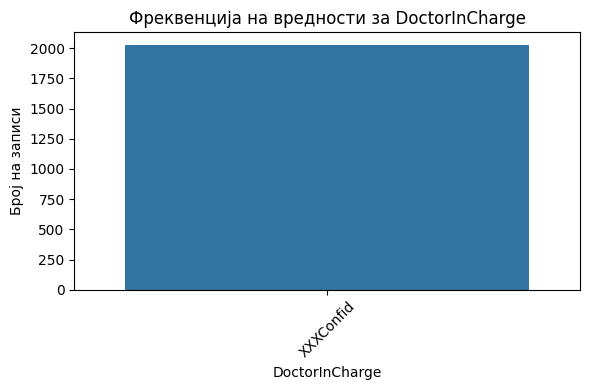

In [14]:

sns.countplot(data=df, x='Diagnosis')
plt.title("Распределба на дијагнози")
plt.show()

df.select_dtypes(include='number').hist(bins=20, figsize=(15, 10))
plt.suptitle("Хистограми на нумерички променливи", fontsize=16)
plt.show()
df_categorical = df.select_dtypes(include='object')

for column in df_categorical.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f"Фреквенција на вредности за {column}")
    plt.xlabel(column)
    plt.ylabel("Број на записи")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


предпроцесирање на податоците


In [15]:
df = df.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols += df.select_dtypes(include='bool').columns.tolist()

le = LabelEncoder()
for col in cat_cols:

    df[col] = df[col].fillna(np.nan)
    mask = df[col].notna()
    df.loc[mask, col] = le.fit_transform(df.loc[mask, col].astype(str))

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
for col in cat_cols:
    df_imputed[col] = df_imputed[col].round().astype(int)


In [16]:
df.head()


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73.0,1,2,0,22.927749,NaN,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89.0,1,2,3,26.827681,NaN,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,NaN,0
2,73.0,1,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,NaN,0,0,7.119548,0,1,0,1,0,0
3,74.0,0,2,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89.0,1,2,3,NaN,0,18.454356,6.310461,NaN,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [17]:
df_imputed.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73.0,1,2,0,22.927749,1,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89.0,1,2,3,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,0,0
2,73.0,1,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,7.821457,0,0,7.119548,0,1,0,1,0,0
3,74.0,0,2,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89.0,1,2,3,27.607810,0,18.454356,6.310461,5.381606,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


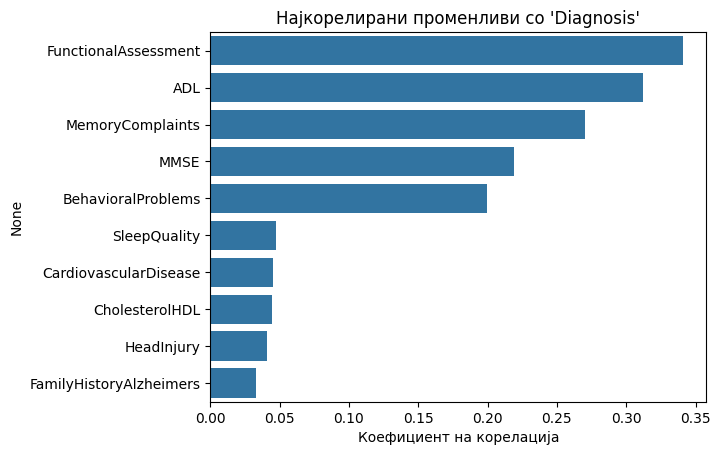

In [18]:
corr = df_imputed.corr()
top_corr_features = corr['Diagnosis'].abs().sort_values(ascending=False)[1:11]
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title("Најкорелирани променливи со 'Diagnosis'")
plt.xlabel("Коефициент на корелација")
plt.show()


делење на податочно множество и скалирање




In [19]:
X = df_imputed.drop("Diagnosis", axis=1)
y = df_imputed["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)


Модели

In [20]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv_strategy,
                           scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Најдобри параметри:", grid_search.best_params_)
print("Најдобра точност (accuracy):", grid_search.best_score_)


Најдобри параметри: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Најдобра точност (accuracy): 0.7265712929690148


Accuracy: 0.7302325581395349

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       274
           1       0.83      0.32      0.46       156

    accuracy                           0.73       430
   macro avg       0.77      0.64      0.64       430
weighted avg       0.76      0.73      0.69       430


Confusion Matrix:


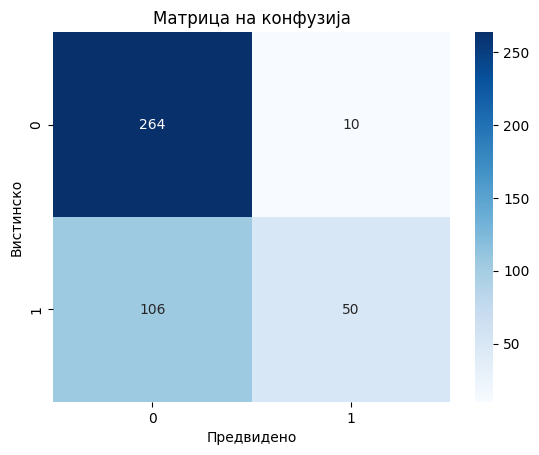

In [21]:
best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица на конфузија")
plt.xlabel("Предвидено")
plt.ylabel("Вистинско")
plt.show()


In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Accuracy: 0.8186046511627907
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       274
           1       0.78      0.70      0.74       156

    accuracy                           0.82       430
   macro avg       0.81      0.79      0.80       430
weighted avg       0.82      0.82      0.82       430



In [23]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.8441860465116279
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       274
           1       0.78      0.79      0.79       156

    accuracy                           0.84       430
   macro avg       0.83      0.83      0.83       430
weighted avg       0.84      0.84      0.84       430



In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.872093023255814
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       274
           1       0.89      0.74      0.81       156

    accuracy                           0.87       430
   macro avg       0.88      0.84      0.86       430
weighted avg       0.87      0.87      0.87       430



In [25]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:38:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9046511627906977
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       274
           1       0.89      0.84      0.86       156

    accuracy                           0.90       430
   macro avg       0.90      0.89      0.90       430
weighted avg       0.90      0.90      0.90       430



In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Neural Network Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Accuracy: 0.800000011920929


Собирање на резултати од сите модели

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Model,Accuracy,ROC AUC
0,Logistic Regression,0.818605,0.884498
1,Decision Tree,0.844186,0.832187
2,Random Forest,0.872093,0.928119
3,XGBoost,0.904651,0.932482
4,Neural Network,0.800000,0.869362


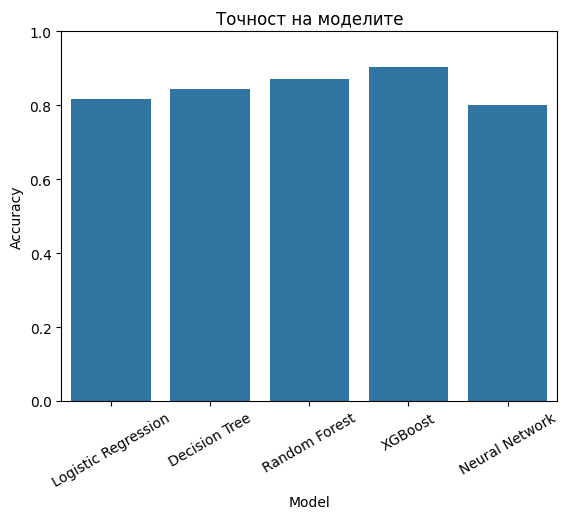

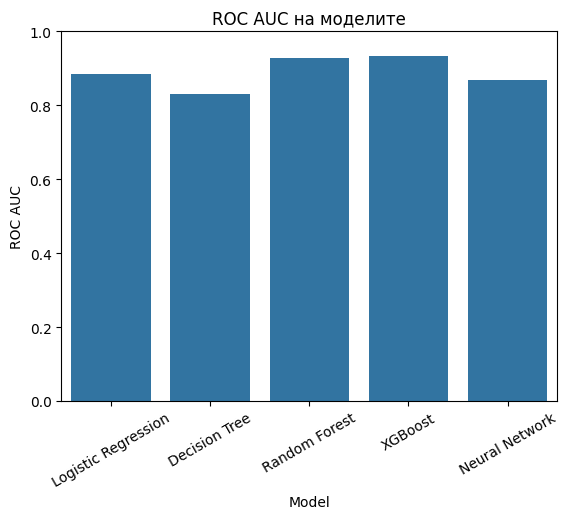

In [27]:
from sklearn.metrics import roc_auc_score

results = {
    "Model": [],
    "Accuracy": [],
    "ROC AUC": []
}

def evaluate_model(name, y_true, y_pred, y_score=None):
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_true, y_pred))
    if y_score is not None:
        results["ROC AUC"].append(roc_auc_score(y_true, y_score))
    else:
        results["ROC AUC"].append(None)

evaluate_model("Logistic Regression", y_test, y_pred_logreg, logreg.predict_proba(X_test)[:,1])
evaluate_model("Decision Tree", y_test, y_pred_dt, dt.predict_proba(X_test)[:,1])
evaluate_model("Random Forest", y_test, y_pred_rf, rf.predict_proba(X_test)[:,1])
evaluate_model("XGBoost", y_test, y_pred_xgb, xgb.predict_proba(X_test)[:,1])
evaluate_model("Neural Network", y_test, (model.predict(X_test) > 0.5).astype(int), model.predict(X_test))

results_df = pd.DataFrame(results)
display(results_df)


sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.title("Точност на моделите")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

sns.barplot(data=results_df, x="Model", y="ROC AUC")
plt.title("ROC AUC на моделите")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


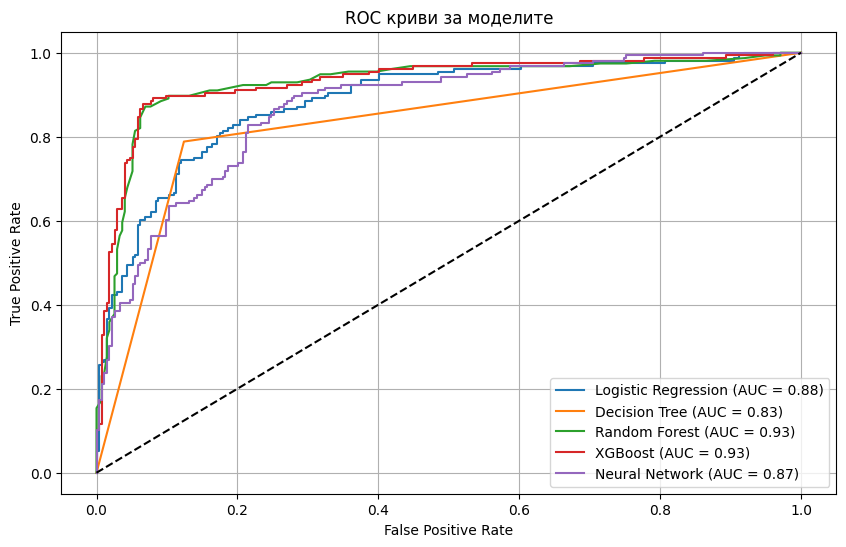

In [28]:

from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))

def plot_roc(model_name, y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_true, y_score):.2f})")

plot_roc("Logistic Regression", y_test, logreg.predict_proba(X_test)[:,1])
plot_roc("Decision Tree", y_test, dt.predict_proba(X_test)[:,1])
plot_roc("Random Forest", y_test, rf.predict_proba(X_test)[:,1])
plot_roc("XGBoost", y_test, xgb.predict_proba(X_test)[:,1])
plot_roc("Neural Network", y_test, model.predict(X_test).flatten())

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC криви за моделите")
plt.legend()
plt.grid()
plt.show()


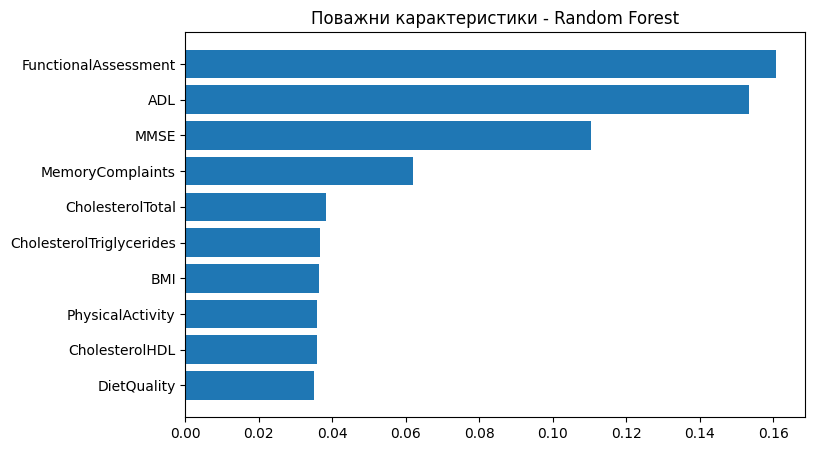

In [29]:

importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), [X.columns[i] for i in indices_rf])
plt.title("Поважни карактеристики - Random Forest")
plt.show()


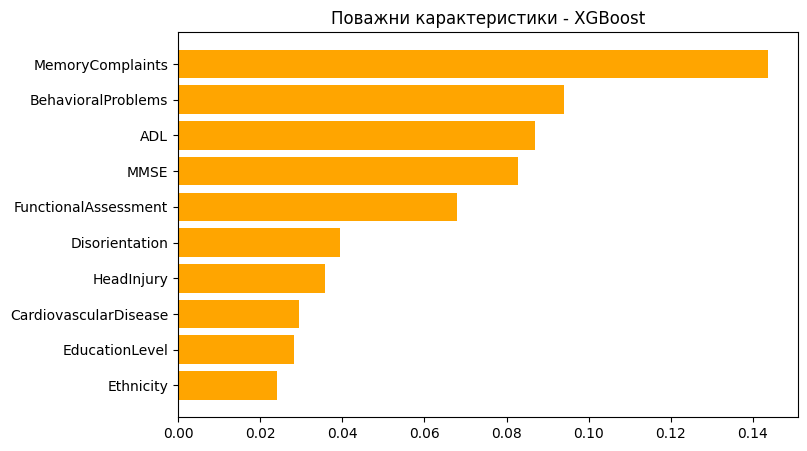

In [30]:

importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center', color='orange')
plt.yticks(range(len(indices_xgb)), [X.columns[i] for i in indices_xgb])
plt.title("Поважни карактеристики - XGBoost")
plt.show()


In [31]:

models = {
    "Logistic Regression": logreg,
    "Decision Tree": dt,
    "Random Forest": rf,
    "XGBoost": xgb,
    "Neural Network": model
}




In [32]:
def manual_patient_input(scaler, results_df, models, df_imputed):
    print(" Внеси податоци за нов пациент.")
    print(" Забелешка: За неважни полиња можеш да внесеш '\\' за празно (ќе се пополнат со KNN).")
    print(" За БИТНИ полиња мора да се внесе вредност.\n")

    map_bin = {"yes": 1, "no": 0}
    map_gender = {"male": 0, "female": 1}
    map_ethnicity = {"caucasian": 0, "african american": 1, "asian": 2, "other": 3}
    map_edu = {"no": 0, "high school": 1, "bachelor's": 2, "higher": 3}

    important_features = [
        "MemoryComplaints", "BehavioralProblems", "FunctionalAssessment", "MMSE", "ADL",
        "Hypertension", "FamilyHistoryAlzheimers", "Ethnicity", "EducationLevel",
        "Diabetes", "CholesterolTriglycerides", "BMI", "CholesterolHDL", "SleepQuality",
        "DietQuality", "CardiovascularDisease", "HeadInjury"
    ]

    input_dict = {}
    features = [
        ("Age", float, "Возраст (60–90 години)", True),
        ("Gender", map_gender, "Пол (male или female)", True),
        ("Ethnicity", map_ethnicity, "Етничка припадност (caucasian, african american, asian, other)", True),
        ("EducationLevel", map_edu, "Образование (no, high school, bachelor's, higher)", True),
        ("BMI", float, "BMI (15–40)", True),
        ("Smoking", map_bin, "Дали пациентот пуши? (yes или no)", True),
        ("AlcoholConsumption", float, "Неделна консумација на алкохол (0–20 единици)", True),
        ("PhysicalActivity", float, "Физичка активност во часови неделно (0–10)", True),
        ("DietQuality", float, "Квалитет на исхрана (0–10)", True),
        ("SleepQuality", float, "Квалитет на спиење (4–10)", True),
        ("FamilyHistoryAlzheimers", map_bin, "Семејна историја на Алцхајмер (yes или no)", True),
        ("CardiovascularDisease", map_bin, "Срцево заболување (yes или no)", True),
        ("Diabetes", map_bin, "Дијабетес (yes или no)", True),
        ("Depression", map_bin, "Депресија (yes или no)", True),
        ("HeadInjury", map_bin, "Повреда на глава (yes или no)", True),
        ("Hypertension", map_bin, "Висок крвен притисок (yes или no)", True),
        ("SystolicBP", float, "Систолен притисок (90–180)", True),
        ("DiastolicBP", float, "Дијастолен притисок (60–120)", True),
        ("CholesterolTotal", float, "Вкупен холестерол (150–300)", True),
        ("CholesterolLDL", float, "LDL холестерол (50–200)", True),
        ("CholesterolHDL", float, "HDL холестерол (20–100)", True),
        ("CholesterolTriglycerides", float, "Триглицериди (50–400)", True),
        ("MMSE", float, "MMSE тест (0–30)", True),
        ("FunctionalAssessment", float, "Функционална проценка (0–10)", True),
        ("MemoryComplaints", map_bin, "Жалби за меморија (yes или no)", True),
        ("BehavioralProblems", map_bin, "Проблеми во однесувањето (yes или no)", True),
        ("ADL", float, "Активности од секојдневниот живот (ADL) (0–10)", True),
        ("Confusion", map_bin, "Збунетост (yes или no)", True),
        ("Disorientation", map_bin, "Дезориентација (yes или no)", True),
        ("PersonalityChanges", map_bin, "Промени во личноста (yes или no)", True),
        ("DifficultyCompletingTasks", map_bin, "Тешкотија при извршување задачи (yes или no)", True),
        ("Forgetfulness", map_bin, "Заборавеност (yes или no)", True)
    ]

    try:
        for feature_name, value_type, description, _ in features:
            if feature_name in important_features:
                allow_blank = False
                note = " Ова поле е БИТНО и не смее да остане празно."
            else:
                allow_blank = True
                note = " Ова поле може да се остави празно со '\\', но е важно за попрецизно предвидување."

            user_input = input(f"{feature_name} – {description} | {note}\n>>> ").strip()

            if user_input == "\\":
                if not allow_blank:
                    raise ValueError(f" '{feature_name}' е БИТНО и мора да се внесе вредност.")
                input_dict[feature_name] = np.nan
            else:
                if isinstance(value_type, dict):
                    input_dict[feature_name] = value_type[user_input.lower()]
                else:
                    input_dict[feature_name] = value_type(user_input)
    except Exception as e:
        print(f"\n Грешка при внес: {e}")
        return

    df_input = pd.DataFrame([input_dict])

    try:
        df_combined = pd.concat([df_imputed, df_input], ignore_index=True)
        imputer = KNNImputer(n_neighbors=5)
        imputed_all = imputer.fit_transform(df_combined)
        df_final_input = pd.DataFrame([imputed_all[-1]], columns=df_combined.columns)
    except Exception as e:
        print(f" KNN импутирањето не успеа: {e}")
        return

    input_scaled = scaler.transform(df_final_input)

    best_model_name = results_df.sort_values(by="ROC AUC", ascending=False).iloc[0]["Model"]
    model = models[best_model_name]
    print(f"\n Се користи моделот: {best_model_name}")

    if best_model_name == "Neural Network":
        prediction = (model.predict(input_scaled) > 0.5).astype(int)[0]
    else:
        prediction = model.predict(input_scaled)[0]

    print("\n Резултат:")
    if prediction == 1:
        print(" Пациентот ИМА висок ризик од Алцхајмер.")
    else:
        print(" Пациентот НЕМА Алцхајмер.")


    print("\n Битни карактеристики според XGBoost:")
    for i, feature in enumerate(important_features, start=1):
        print(f"{i}. {feature}")


In [33]:
manual_patient_input(scaler, results_df, models, X)


 Внеси податоци за нов пациент.
 Забелешка: За неважни полиња можеш да внесеш '\' за празно (ќе се пополнат со KNN).
 За БИТНИ полиња мора да се внесе вредност.

Age – Возраст (60–90 години) |  Ова поле може да се остави празно со '\', но е важно за попрецизно предвидување.
>>> 65
Gender – Пол (male или female) |  Ова поле може да се остави празно со '\', но е важно за попрецизно предвидување.
>>> male
Ethnicity – Етничка припадност (caucasian, african american, asian, other) |  Ова поле е БИТНО и не смее да остане празно.
>>> other
EducationLevel – Образование (no, high school, bachelor's, higher) |  Ова поле е БИТНО и не смее да остане празно.
>>> no
BMI – BMI (15–40) |  Ова поле е БИТНО и не смее да остане празно.
>>> 16
Smoking – Дали пациентот пуши? (yes или no) |  Ова поле може да се остави празно со '\', но е важно за попрецизно предвидување.
>>> no
AlcoholConsumption – Неделна консумација на алкохол (0–20 единици) |  Ова поле може да се остави празно со '\', но е важно за попре